In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from architecture.classifier import DeepBinaryClassifier
from architecture.nodes.ripper import make_ripper_node
from architecture.utils import describe_architecture

In [2]:
dataset_df = pd.read_csv("./data/10_bit_artificial/107.csv")
input_values = dataset_df.drop(columns="class").to_numpy(bool)
target_values = dataset_df["class"].to_numpy(bool)

input_values_train, input_values_test, target_values_train, target_values_test\
    = train_test_split(input_values, target_values, test_size=0.2, random_state=42, stratify=target_values)

print("Small dataset shapes:")
print(f"input_values_train: {input_values_train.shape}, input_values_test: {input_values_test.shape}")
print(f"target_values_train: {target_values_train.shape}, target_values_test: {target_values_test.shape}")

Small dataset shapes:
input_values_train: (819, 10), input_values_test: (205, 10)
target_values_train: (819,), target_values_test: (205,)


In [3]:
multipler = 16

config = dict(
    layer_node_counts=[multipler * 512, multipler * 256, multipler * 128, multipler * 64],
    layer_bit_counts=[2]*4,
    seed=42,
)

net = DeepBinaryClassifier(**config, node_factory=make_ripper_node, jobs=8)
%time net.fit(input_values_train, target_values_train)

pred_values_test = net.predict(input_values_test)        # (N, 2)
targets = np.broadcast_to(target_values_test[:, None], pred_values_test.shape)

accuracies_test = (pred_values_test == targets).mean(axis=0)

best_idx = int(np.argmax(accuracies_test))
best_name = net.node_names[-1][best_idx]

print("Best node:", best_name, "with accuracy", accuracies_test[best_idx])

CPU times: user 9.21 s, sys: 1.54 s, total: 10.7 s
Wall time: 33.7 s
Best node: L4N96 with accuracy 0.8829268292682927


In [4]:
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "font.family": "DejaVu Sans",
    "font.weight": "bold"
})

def format_subscripts(name: str) -> str:
    """Format digits in names as subscripts (e.g. L2N7 -> $N_{7}$)."""
    return "$" + re.sub(r"([A-Za-z]+)(\d+)", r"\1_{\2}", name) + "$"

def plot_architecture_networkx(
        desc,
        *,
        layer_separation: float = 3.2,
        node_separation: float = 1.35,
        node_font_size: float = 12.0,
        header_font_size: float = 14.0,
        edge_width: float = 1.6,
        dpi: int = 60
):
    layers = desc["layers"]

    graph = nx.DiGraph()
    node_positions, node_labels = {}, {}
    for layer_idx, layer in enumerate(layers):
        node_names = [node["name"] for node in layer["nodes"]]
        num_nodes = len(node_names)

        node_y_positions = (np.arange(num_nodes)[::-1] - (num_nodes - 1) / 2.0) * node_separation
        node_x_positions = np.full(num_nodes, layer_idx * layer_separation)

        for node_idx, node_name in enumerate(node_names):
            node_positions[node_name] = (node_x_positions[node_idx], node_y_positions[node_idx])

            node_label = "N" + node_name.split("N", 1)[1]
            node_labels[node_name] = format_subscripts(node_label)

            for node_backlinks in layer["nodes"][node_idx].get("backlinks", []):
                if node_backlinks in node_positions:
                    graph.add_edge(node_backlinks, node_name)

    graph.add_nodes_from(node_positions)

    # layout and plot
    node_area = (node_font_size * 2.4) ** 2
    x_padding = 0.6 * layer_separation
    y_padding = 0.8 * node_separation
    header_offset = 0.6 * node_separation

    num_layers = max(1, len(layers))
    node_y_positions = [pos[1] for pos in node_positions.values()] or [0.0]
    node_y_min, node_y_max = min(node_y_positions), max(node_y_positions)
    node_x_min, node_x_max = -x_padding, (num_layers - 1) * layer_separation + x_padding
    node_y_min, node_y_max = node_y_min - y_padding, node_y_max + y_padding + header_offset

    figsize = ((node_x_max - node_x_min) * 0.90, (node_y_max - node_y_min) * 0.86)
    face_color = "white"
    draw_color = "black"

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_facecolor(face_color)

    nx.draw_networkx_edges(graph, node_positions, width=edge_width, edge_color=draw_color, arrows=False, ax=ax, alpha=0.95)
    nx.draw_networkx_nodes(graph, node_positions, node_size=node_area, node_color=face_color, edgecolors=draw_color, linewidths=edge_width, ax=ax)
    nx.draw_networkx_labels(graph, node_positions, labels=node_labels, font_size=node_font_size, font_weight="bold", font_color=draw_color, ax=ax)

    ax.set_xlim(node_x_min, node_x_max)
    ax.set_ylim(node_y_min, node_y_max)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    # headers
    layer_titles = [format_subscripts(layer["name"]) for layer in layers]
    header_y_position = max(node_y_positions) + y_padding * 0.4 + header_offset

    for layer_idx, title in enumerate(layer_titles):
        header_x_position = layer_idx * layer_separation
        ax.text(header_x_position, header_y_position, title, ha="center", va="bottom", color=draw_color, fontweight="bold", fontsize=header_font_size)

    plt.show()

In [5]:
net.prune(output_node_names=[best_name])

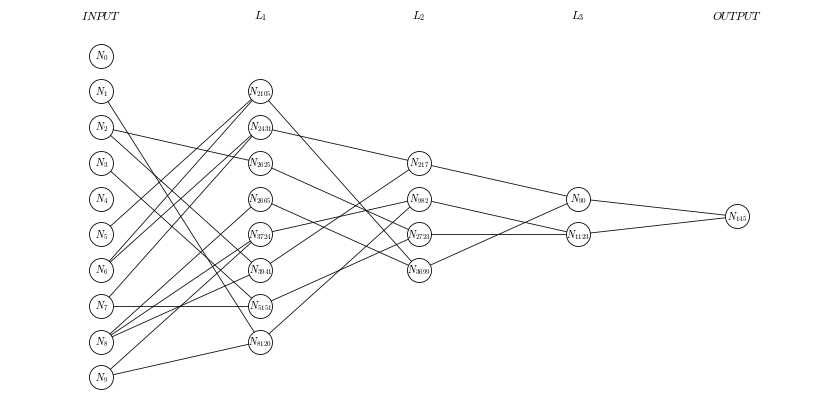

In [6]:
desc = describe_architecture(net)
plot_architecture_networkx(
    desc,
    layer_separation=4,
    node_separation=0.9,
    header_font_size = 14.0,
    edge_width=1,
)